**ANN based Model development of Planar InGaAs MOS Transistor**</br>
*This model will be deployed in Verilog-AMS language to maintain SPICE compatibility*

**Import Required libraries**

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**Load the dataset containing Id-Vg TCAD simulation data**</br>
*Replace the Zero values using a  small number*

In [2]:
df = pd.read_csv('dataset_Ingaas.csv')
df[df < 0] = 0
df["Id"].replace({0: 1e-15}, inplace=True)
df["Vds"].replace({0: 1e-3}, inplace=True)
df["Vgs"].replace({0: 1e-3}, inplace=True)
#df.head()
X = np.log10(df.iloc[:,0:4])
print(X.head())

       tox       Lg  Vds       Vgs
0 -0.30103  1.69897 -3.0 -3.000000
1 -0.30103  1.69897 -3.0 -1.000000
2 -0.30103  1.69897 -3.0 -0.698970
3 -0.30103  1.69897 -3.0 -0.522879
4 -0.30103  1.69897 -3.0 -0.397940


*Prepare the dataframe for training and normalizing it by taking Log of all input features*

*Rescale the target variable (drain current) by taking log*

In [9]:
print(df['Id'])

0       4.580000e-16
1       1.000000e-15
2       1.000000e-15
3       1.000000e-15
4       1.000000e-15
            ...     
4710    2.570820e-03
4711    2.614940e-03
4712    2.651730e-03
4713    2.680840e-03
4714    2.706590e-03
Name: Id, Length: 4715, dtype: float64


In [3]:
yy = np.ravel(df['Id'])
y =  -1/np.log10(yy)
print(y)

[0.06519273 0.06666667 0.06666667 ... 0.38812784 0.38884344 0.38947217]


**Perform Train-test Splitting**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(X_train.shape)

(3772, 4)


**Build the Sequential model in Tensorflow-Keras** </br>
*Train the model for 300 iterations*

In [5]:
model = tf.keras.Sequential()
opt = keras.optimizers.Adam(learning_rate=0.001)
#loss=tf.keras.losses.MeanSquaredLogarithmicError()
#loss=tf.keras.losses.MeanAbsoluteError()
loss = tf.keras.losses.MeanSquaredError()
model.add(keras.layers.Dense(16, activation='tanh', input_shape=(4,)))
model.add(keras.layers.Dense(16, activation='tanh'))
model.add(keras.layers.Dense(8, activation='tanh'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
#model.add(keras.layers.Dense(1))
model.compile(optimizer=opt, loss=loss, metrics=['mae'])
history_1 = model.fit(X_train, y_train, epochs=300,batch_size=5)
#history_1 = model.fit(X_train, y_train, batch_size=1,epochs=10)

Epoch 1/300
755/755 [==============================] - 5s 3ms/step - loss: 0.0058 - mae: 0.0424
Epoch 2/300
755/755 [==============================] - 3s 3ms/step - loss: 3.7384e-04 - mae: 0.0150
Epoch 3/300
755/755 [==============================] - 2s 3ms/step - loss: 2.4956e-04 - mae: 0.0126
Epoch 4/300
755/755 [==============================] - 2s 3ms/step - loss: 2.1957e-04 - mae: 0.0118
Epoch 5/300
755/755 [==============================] - 2s 3ms/step - loss: 2.0973e-04 - mae: 0.0114
Epoch 6/300
755/755 [==============================] - 3s 5ms/step - loss: 1.8773e-04 - mae: 0.0109
Epoch 7/300
755/755 [==============================] - 3s 4ms/step - loss: 1.7089e-04 - mae: 0.0103
Epoch 8/300
755/755 [==============================] - 3s 4ms/step - loss: 1.6258e-04 - mae: 0.0100
Epoch 9/300
755/755 [==============================] - 3s 3ms/step - loss: 1.5260e-04 - mae: 0.0097
Epoch 10/300
755/755 [==============================] - 2s 3ms/step - loss: 1.3120e-04 - mae: 0.0088
Epo

*save the model in machine for future use*

In [6]:
# save model
model.save('m16_16_8_1.h5')
print('Model Saved!')
 


Model Saved!


*You can load the pre-trained model if required*

In [16]:
# load model
#from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
savedModel=load_model('m16_16_8_1.h5')
savedModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                80        
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


*Print the training loss with iterations*

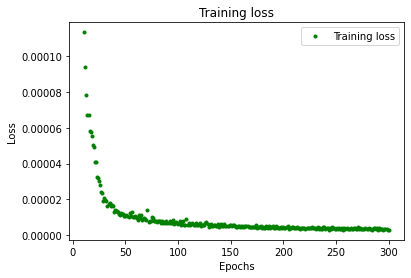

In [7]:
loss = history_1.history['loss']
#val_loss = history_1.history['val_loss']
epochs = range(1, len(loss) + 1)
SKIP = 10
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
#plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Applying new data to trained model for prediction**</br>
*Before applying, new data must be normalized same as before which we did before training*</br>
*Make sure that features are in a same sequence same as training set*

In [8]:
#%%
# New data input for testing
df_test = pd.read_csv('test01.csv')
df_test[df_test < 0] = 0
df_test["Id"].replace({0: 1e-15}, inplace=True)
df_test["Vds"].replace({0: 1e-3}, inplace=True)
df_test["Vgs"].replace({0: 1e-3}, inplace=True)
#df.head()
Xnew = np.log10(df_test.iloc[:,0:4])
ynew=np.ravel(df_test["Id"])
print(Xnew)
print(df_test.head())

        tox       Lg      Vds       Vgs
0  -0.30103  1.69897 -0.30103 -3.000000
1  -0.30103  1.69897 -0.30103 -1.000000
2  -0.30103  1.69897 -0.30103 -0.698970
3  -0.30103  1.69897 -0.30103 -0.522879
4  -0.30103  1.69897 -0.30103 -0.397940
5  -0.30103  1.69897 -0.30103 -0.301030
6  -0.30103  1.69897 -0.30103 -0.221849
7  -0.30103  1.69897 -0.30103 -0.154902
8  -0.30103  1.69897 -0.30103 -0.096910
9  -0.30103  1.69897 -0.30103 -0.045757
10 -0.30103  1.69897 -0.30103  0.000000
11 -0.30103  1.69897 -0.30103  0.041393
12 -0.30103  1.69897 -0.30103  0.079181
13 -0.30103  1.69897 -0.30103  0.113943
14 -0.30103  1.69897 -0.30103  0.146128
15 -0.30103  1.69897 -0.30103  0.176091
16 -0.30103  1.69897 -0.30103  0.204120
17 -0.30103  1.69897 -0.30103  0.230449
18 -0.30103  1.69897 -0.30103  0.255273
19 -0.30103  1.69897 -0.30103  0.278754
20 -0.30103  1.69897 -0.30103  0.301030
   tox  Lg  Vds    Vgs        Id
0  0.5  50  0.5  0.001  0.000115
1  0.5  50  0.5  0.100  0.000137
2  0.5  50  0.5  0.20

**Plot the Predicted value along with actual (TCAD) value**

1/1 [==============================] - 0s 47ms/step


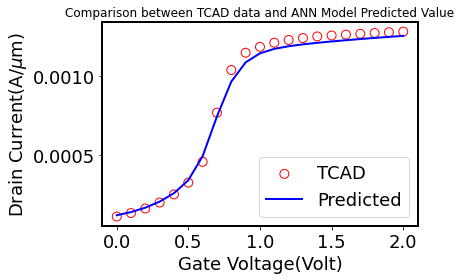

In [10]:
#Normalize validation data
yval=-1/np.log10(ynew)
yval=yval.reshape(-1,1)
#print(yval)
#%%
# Predict the new dataset
y_pred = model.predict(Xnew)
#plot the result
vg1=df_test["Vgs"]
vg=np.ravel(vg1)
vg=vg.reshape(-1,1)
#plt.rcParams["figure.figsize"] = [4, 3]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['axes.linewidth'] = 2
fig, ax = plt.subplots()
#print(vg)
#plt.plot(vg, 10**(-1/yval), 'ro', label='Actual')
#plt.yscale("log") #comment this line if you want to plot in linear scale
plt.scatter(vg, 10**(-1/yval), s=80, facecolors='none', edgecolors='r', label='TCAD')
plt.plot(vg,10**(-1/y_pred), 'b', label='Predicted',linewidth=2)
plt.title('Comparison between TCAD data and ANN Model Predicted Value')
plt.xlabel('Gate Voltage(Volt)', fontsize=18)
plt.ylabel('Drain Current(A/$\mu$m)',fontsize=18)
plt.legend(fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
plt.savefig("idvg.png", format="png", dpi=300)
plt.show()

**Error Metric calculation**
</br>
*Error Metrics are: MSE, RMSE and MAE*

In [86]:
yval = yval.reshape(1,-1)[0]
y_pred = y_pred.reshape(1,-1)[0]
#print(y_pred)

In [87]:
#calcularion of R^2 value
corr_matrix = np.corrcoef(yval, y_pred)
corr = corr_matrix[0,1]
R_sq = corr**2
 
print("R Square value:",R_sq)
#%%Calculation of MSE
MSE = (1/len(yval))*np.sum((yval - y_pred)**2)
print("MSE is:",MSE/1e-6)
#Calculation of MAE
MAE = (1/len(yval))*np.sum((yval - y_pred))
print("MAE is:", MAE/1e-3)
#calculation of RMSE error
rms_err = np.sqrt((1/len(yval))*np.sum((yval - y_pred)**2))
print("RMSE Error:",rms_err/1e-3)

R Square value: 0.9998970806153552
MSE is: 3.5845487408840575
MAE is: 0.6697628072274054
RMSE Error: 1.8932904533863941


**Model parameter extraction to txt file for Verilog-A Implementation**</br>
*Under implementation*